In [91]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
from netCDF4 import Dataset
import multiprocessing
import scipy
from histogram import histogram, percentile_from_histogram, value_from_histogram

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

From previous testing, the inclusion of supplemental locations in quantile mapping induces modest improvements in the bias from the analysis, but more significant is the large decrease in forecast skill for some locations. 

I am sure the performance of the supplemental locations can be improved by cherry picking the best locations (instead of just using all 50). In Hamill+2017 (the NBM paper) they use only the SLs with a penalty value below some number (in their case, it was $\Delta$ = 0.3 but that obviously depends on the choice of penalty weights, etc.), which is an easy test. We could also use the Pearson correlations similarly, though this would  of course select the "best" locations based on climotology alone, which could be risky given that the penalty function weighs differences in terrain higher than differences in climotology. 

Other tests will neccesitate changing the actual SL algorithm: one idea is to just simply weight the climotology higher than the terrain. The other is to keep the overall weights the same but change the internal weighting of the percentiles used to quantify the difference in climotologies. In essence, the precipitation CDF penalty function can be reworked to put heavier weight on top percentiles of precipitation, with the reasoning of it’s more important to match extreme/significant precip events than it is to match small amounts

Below, will look into (1) selecting only the "best" SLs from the limit_water_v4 model run, (2) editing the SL code to put more power in the 75th and above percentiles (for instance, 75th percentile and above get multiplied by 1.5) and, (3) again editing teh SL to increase the overall weight of the precipitation penalty.


## utils

In [2]:
from nimbl import stations  #.from_mos2ktbl

#selected stations for analysis
station_data = '//scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/common/mdl_station.tbl'
station_points = stations.from_mos2ktbl(station_data, ['KSEA','KMSP','KBOS', 'KLAS','KLIT','KMCO', 'KDEN', 'KCVG'])

#rename weird ones
st_names = station_points['name'].copy()
st_names[3] = 'Las Vegas'
st_names[6] = 'Denver'
st_names[8] = 'Cincinnati'

In [3]:
#get CONUS lat/lons
ds = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_4.co.2p5.nc',
             mode="r")

#unpack lats and lons to index over
lat_arr = ds.latitude.data
lon_arr = ds.longitude.data
ds.close()

In [4]:
def get_nearest_grid(lat_input, long_input):
    # Get indices of the nearest lat/lon values
    # Lat/long input will be values corresponding to chosen stations
    lat_index, lon_index = [],[]


    for i in range(len(lat_input)):
        a = np.abs(lat_arr-station_lats[i]) + np.abs(lon_arr-station_lons[i])
        i,j = np.unravel_index(a.argmin(), a.shape)
        lat_index.append(i)
        lon_index.append(j)
    return lat_index, lon_index

def to360(x):
    return (x - 180) % 360 + 180

station_lats = station_points['lat']
station_lons = to360(station_points['lon']) #need to convert from E/W to 0-360

lat_idx, lon_idx = get_nearest_grid(station_lats, station_lons)

conus_gp = (lat_idx, lon_idx)

In [13]:
def convert_datetime64_to_datetime( usert: np.datetime64 )->datetime.datetime:
    t = np.datetime64( usert, 'us').astype(datetime.datetime)
    return t

#first, get CONUS grid info
from nimbl.metadata import get_metadata
import grib2io

conus_grid_def = get_metadata('grib2_section3', model='blend',region='co' )
conus_grid = grib2io.Grib2GridDef(conus_grid_def[4], conus_grid_def[5:])

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/nimbl/metadata/metadata.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadata_df = pd.concat(collect, axis="index")


# Using SLs below Penalty Threshold

In [5]:
## First, supplemental location data
month = 7
sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4//blend.supplemental_locations_{month}.co.2p5.nc')
#unpack lats and lons to index over
lat_arr = sl.latitude.data
lon_arr = sl.longitude.data

xlocs = sl.xlocations.data
ylocs = sl.ylocations.data

differences = sl.differences.data

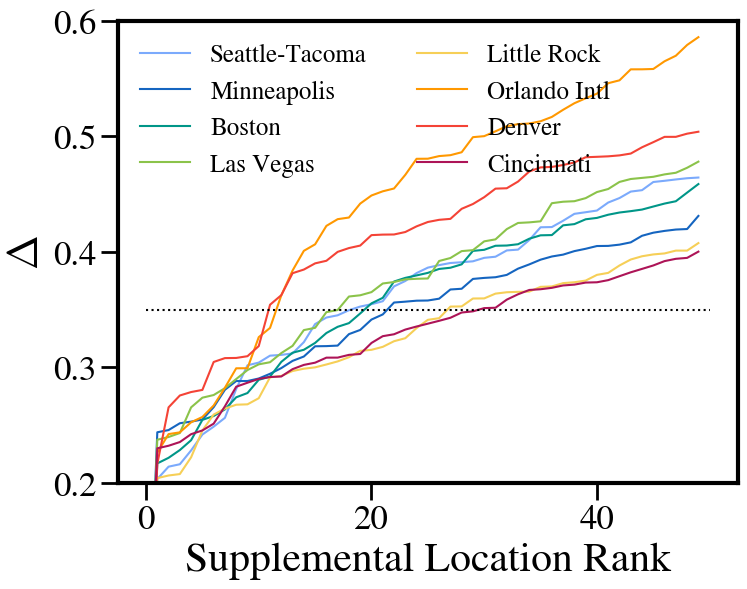

In [6]:
diffs_at_locs = differences[:,conus_gp[0], conus_gp[1]]
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

for i in range(len(st_names)):
    if i == 7:
        #skip duplicated Denver station
        continue
    plt.plot(np.arange(50), diffs_at_locs[:,i], color=colors[i],label=st_names[i].title())

plt.plot([0,50],[0.35,0.35], ls=':', color='black')

plt.ylabel(f'$\Delta$')
plt.xlabel('Supplemental Location Rank')

plt.ylim([0.2,0.6])
plt.legend(frameon=False, fontsize=18,ncol=2)

In [7]:
#penalty threshold, only SLs with differences < threshold are used
threshold = 0.35

for stat in range(len(st_names)):
    sl_above_threshold = np.where(diffs_at_locs[:,stat] <= threshold)[0]
    print(f"{st_names[stat].title()} has {len(sl_above_threshold)} SLs below threshold")

print("-------------------------------")

Seattle-Tacoma has 19 SLs below threshold
Minneapolis has 22 SLs below threshold
Boston has 20 SLs below threshold
Las Vegas has 18 SLs below threshold
Little Rock has 27 SLs below threshold
Orlando Intl has 12 SLs below threshold
Denver has 11 SLs below threshold
Denver Stapleton has 10 SLs below threshold
Cincinnati has 30 SLs below threshold
-------------------------------


One complication: if we have different numbers of SLs for each location, I can't stack them together like above. 

Do I make a ragged list of lists?

Update: This way isn't viable...in order to make the histograms for the quantile mapping, we have to turn the nested arrays into DataArrays, which can only work if all dimenions are the same legnth -- this won't be true if we select by threshold. Perhaps we take the average # of SLs below the threshold?

In [8]:
#penalty threshold, only SLs with differences < threshold are used
threshold = 0.35
num_sls = []

print(f"THRESHOLD = {threshold}")
for stat in range(len(st_names)):
    sl_above_threshold = np.where(diffs_at_locs[:,stat] <= threshold)[0]
    num_sls.append(len(sl_above_threshold))
    print(f"{st_names[stat].title()} has {num_sls[-1]} SLs below threshold")

print("-------------------------------")
print(f'Average # of SLs below threshold = {int(np.mean(num_sls))}')
ave_under_thresh = int(np.mean(num_sls))

THRESHOLD = 0.35
Seattle-Tacoma has 19 SLs below threshold
Minneapolis has 22 SLs below threshold
Boston has 20 SLs below threshold
Las Vegas has 18 SLs below threshold
Little Rock has 27 SLs below threshold
Orlando Intl has 12 SLs below threshold
Denver has 11 SLs below threshold
Denver Stapleton has 10 SLs below threshold
Cincinnati has 30 SLs below threshold
-------------------------------
Average # of SLs below threshold = 18


This way, we take the first 18 SLs (can do this since the SLs are saved in rank order w.r.t. difference)

In [ ]:
## GEFS
sl_precip_at_stations = np.zeros((60, 30, len(st_names),ave_under_thresh)) #days, ensemble mems, stations, each station's SLs

start_day = datetime.date(2024,month,22)


for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    for mem in range(1,31):
        file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96'
        ds = xr.open_dataset(file, engine='grib2io')
        ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
        precip = ds_to_co.APCP.data
        for stat in range(len(st_names)):
            for sl in range(ave_under_thresh):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_precip_at_stations[day, mem-1, stat,sl] = precip[y_thisloc, x_thisloc]


        

In [ ]:
## URMA ##
sl_urma_at_stations = np.zeros((60,len(st_names),ave_under_thresh)) #days, stations, each station's SLs

for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    #pcpurma_ak.2024060500.06h.grb2
    file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/urma2p5.{this_day.strftime("%Y%m%d")}00.pcp_06h.wexp.grb2'
    ds = xr.open_dataset(file, engine='grib2io')
    ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
    precip = ds_to_co.APCP.data
    for stat in range(len(st_names)):
            for sl in range(ave_under_thresh):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_urma_at_stations[day, stat,sl] = precip[y_thisloc, x_thisloc]

In [ ]:
#set precip < 0.254 mm == 0 precip
clip_precip = np.where(sl_precip_at_stations<0.254, 0., sl_precip_at_stations)
clip_urma = np.where(sl_urma_at_stations<0.254, 0., sl_urma_at_stations)

In [ ]:
#set up histograms
gefs_precip = xr.DataArray(data=clip_precip, dims=['day', 'member', 'station', 'location'], 
                           coords=dict(day=np.arange(60), member=np.arange(30), station=st_names, location=np.arange(ave_under_thresh)),
                          name='APCP')

urma_precip = xr.DataArray(data=clip_urma, dims=['day','station', 'location'], 
                           coords=dict(day=np.arange(60), station=st_names, location=np.arange(ave_under_thresh)),
                          name='APCP')

In [ ]:
bins = np.logspace(np.log10(0.254), 1.7, 500)#np.arange(0,20,0.1)
bins = np.insert(bins, 0, 0.)
urma_hist = histogram(urma_precip, bins)
gefs_hist = histogram(gefs_precip, bins)

In [ ]:
#without SLs
p = percentile_from_histogram(gefs_hist.sum(dim='member').sel(location=0), gefs_precip[:,:,:,0])
v = value_from_histogram(urma_hist.sel(location=0), p)

In [ ]:
#with SLs
p_with_sl = percentile_from_histogram(gefs_hist.sum(dim='member').sum(dim='location'), gefs_precip)
v_with_sl = value_from_histogram(urma_hist.sum(dim='location'), p_with_sl)

In [ ]:
#when is GEFS data valid
mem = 4
temp = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{start_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96',
                      engine='grib2io')
dt = convert_datetime64_to_datetime(temp.validDate.data).strftime("%Y%m%d")
temp.close()

In [ ]:
### URMA analysis for date corresponding to GEFS valid time ###
a = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{dt}/urma2p5.{dt}00.pcp_06h.wexp.grb2',
                   engine='grib2io')

In [ ]:
a_to_co = a.grib2io.interp('bilinear', conus_grid)
a_at_stations = a_to_co.APCP.data[conus_gp[0], conus_gp[1]]

In [ ]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
hrange=(-6.5,6.5)
axes[0,0].set_ylim([0,2.5])
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].hist(np.ravel(gefs_precip[0,:,stat,0])-a_at_stations[stat], range=hrange, bins=25, density=True, alpha=0.3, color='gray',label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, 0,:])-a_at_stations[stat], range=hrange, bins=25,histtype='step', lw=3,color=colors[stat],density=True,label='No SL')
        axes[i,j].hist(np.ravel(v_with_sl[stat, 0,:,:])-a_at_stations[stat], range=hrange, bins=25,alpha=0.4,color=colors[stat],density=True,label='With SL')
        axes[i,j].plot([0,0], [0,3], ls=':', lw=1.5, color='black')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
axes[0,0].legend(frameon=False, fontsize=15, loc='upper left')

fig.text(x=0.36, y=-0.05, s='Forecast - Analysis', fontdict={'fontsize': 40})
fig.text(x=0.051, y=0.5, s='P', rotation='vertical',fontdict={'fontsize': 35})

# Larger Weight on High-end Percentiles

Change in code:


Original:

                ! STEP 1: Preciptiation CDF Penalty
                ! Generate precipitation values assocated with each quantile for the grid point of interest (i,j)
                ! and a potential supplemental location (ii,jj).
                do n=1,99 !nquantiles
                    gammapcp_diff=gammapcp_diff+abs(gammapcp_quantiles(i,j,n)-gammapcp_quantiles(ii,jj,n))
                end do




New:

                ! STEP 1: Preciptiation CDF Penalty
                ! Generate precipitation values assocated with each quantile for the grid point of interest (i,j)
                ! and a potential supplemental location (ii,jj).
                do n=1,99 !nquantiles
                    if(n.gt.74)then ! above 75th percentile
                        gammapcp_diff=gammapcp_diff+(abs(gammapcp_quantiles(i,j,n)-gammapcp_quantiles(ii,jj,n))*high_percentile_weight)
                    else
                        gammapcp_diff=gammapcp_diff+abs(gammapcp_quantiles(i,j,n)-gammapcp_quantiles(ii,jj,n))
                    endif
                end do

In [31]:
## First, supplemental location data
month = 1
sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/weight_climo_percentiles/blend.supplemental_locations_{month}.co.2p5.nc')
#unpack lats and lons to index over
lat_arr = sl.latitude.data
lon_arr = sl.longitude.data

xlocs = sl.xlocations.data
ylocs = sl.ylocations.data

differences = sl.differences.data


In [141]:
## GEFS
sl_precip_at_stations = np.zeros((60, 30, len(st_names),50)) #days, ensemble mems, stations, each station's SLs

start_day = datetime.date(2023,month,15)


for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    for mem in range(1,31):
        file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96'
        ds = xr.open_dataset(file, engine='grib2io')
        ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
        precip = ds_to_co.APCP.data
        for stat in range(len(st_names)):
            for sl in range(50):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_precip_at_stations[day, mem-1, stat,sl] = precip[y_thisloc, x_thisloc]


## URMA ##
sl_urma_at_stations = np.zeros((60,len(st_names),50)) #days, stations, each station's SLs

for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    #pcpurma_ak.2024060500.06h.grb2
    file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/urma2p5.{this_day.strftime("%Y%m%d")}00.pcp_06h.wexp.grb2'
    try:
        ds = xr.open_dataset(file, engine='grib2io')
    except:
        bad_count += 1
        sl_urma_at_stations[day, stat,sl] = np.nan
        continue
    ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
    precip = ds_to_co.APCP.data
    for stat in range(len(st_names)):
            for sl in range(50):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_urma_at_stations[day, stat,sl] = precip[y_thisloc, x_thisloc]        

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [134]:
#set precip < 0.254 mm == 0 precip
clip_precip = np.where(sl_precip_at_stations<0.254, 0., sl_precip_at_stations)
clip_urma = np.where(sl_urma_at_stations<0.254, 0., sl_urma_at_stations)

In [135]:
#set up histograms
gefs_precip = xr.DataArray(data=clip_precip, dims=['day', 'member', 'station', 'location'], 
                           coords=dict(day=np.arange(60), member=np.arange(30), station=st_names, location=np.arange(50)),
                          name='APCP')

urma_precip = xr.DataArray(data=clip_urma, dims=['day','station', 'location'], 
                           coords=dict(day=np.arange(60), station=st_names, location=np.arange(50)),
                          name='APCP')

In [136]:
bins = np.logspace(np.log10(0.254), 1.7, 500)#np.arange(0,20,0.1)
bins = np.insert(bins, 0, 0.)
urma_hist = histogram(urma_precip, bins)
gefs_hist = histogram(gefs_precip, bins)

In [137]:
#without SLs
p = percentile_from_histogram(gefs_hist.sum(dim='member').sel(location=0), gefs_precip[:,:,:,0])
v = value_from_histogram(urma_hist.sel(location=0), p)

In [138]:
#with SLs
p_with_sl = percentile_from_histogram(gefs_hist.sum(dim='member').sum(dim='location'), gefs_precip)
v_with_sl = value_from_histogram(urma_hist.sum(dim='location'), p_with_sl)

In [55]:
#when is GEFS data valid
mem = 4
temp = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{start_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96',
                      engine='grib2io')
dt = convert_datetime64_to_datetime(temp.validDate.data).strftime("%Y%m%d")
temp.close()

In [56]:
### URMA analysis for date corresponding to GEFS valid time ###
a = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{dt}/urma2p5.{dt}00.pcp_06h.wexp.grb2',
                   engine='grib2io')

In [57]:
a_to_co = a.grib2io.interp('bilinear', conus_grid)
a_at_stations = a_to_co.APCP.data[conus_gp[0], conus_gp[1]]

Text(0.051, 0.5, 'P')

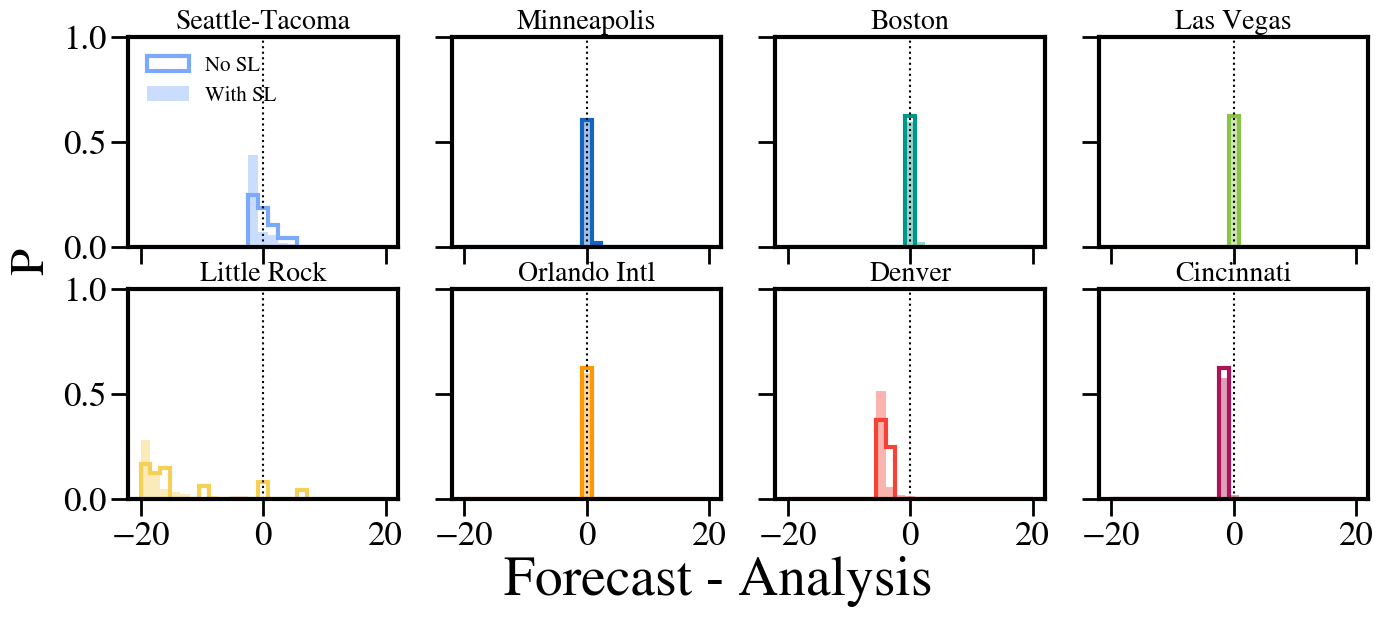

In [58]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
hrange=(-20,20)
axes[0,0].set_ylim([0,1.])
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        #axes[i,j].hist(np.ravel(gefs_precip[0,:,stat,0])-a_at_stations[stat], range=hrange, bins=25, density=True, alpha=0.3, color='gray',label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, 0,:])-a_at_stations[stat], range=hrange, bins=25,histtype='step', lw=3,color=colors[stat],density=True,label='No SL')
        axes[i,j].hist(np.ravel(v_with_sl[stat, 0,:,:])-a_at_stations[stat], range=hrange, bins=25,alpha=0.4,color=colors[stat],density=True,label='With SL')
        axes[i,j].plot([0,0], [0,3], ls=':', lw=1.5, color='black')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
axes[0,0].legend(frameon=False, fontsize=15, loc='upper left')

fig.text(x=0.36, y=-0.05, s='Forecast - Analysis', fontdict={'fontsize': 40})
fig.text(x=0.051, y=0.5, s='P', rotation='vertical',fontdict={'fontsize': 35})

what

In [150]:

month = 1


# weight higher percentiles
sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/weight_climo_percentiles/blend.supplemental_locations_{month}.co.2p5_weight3.nc')
differences_w = sl.differences.data
sl.close()


# original
sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_{month}.co.2p5.nc')
differences_o = sl.differences.data
sl.close()



Text(0.051, 0.5, '$\\Delta$')

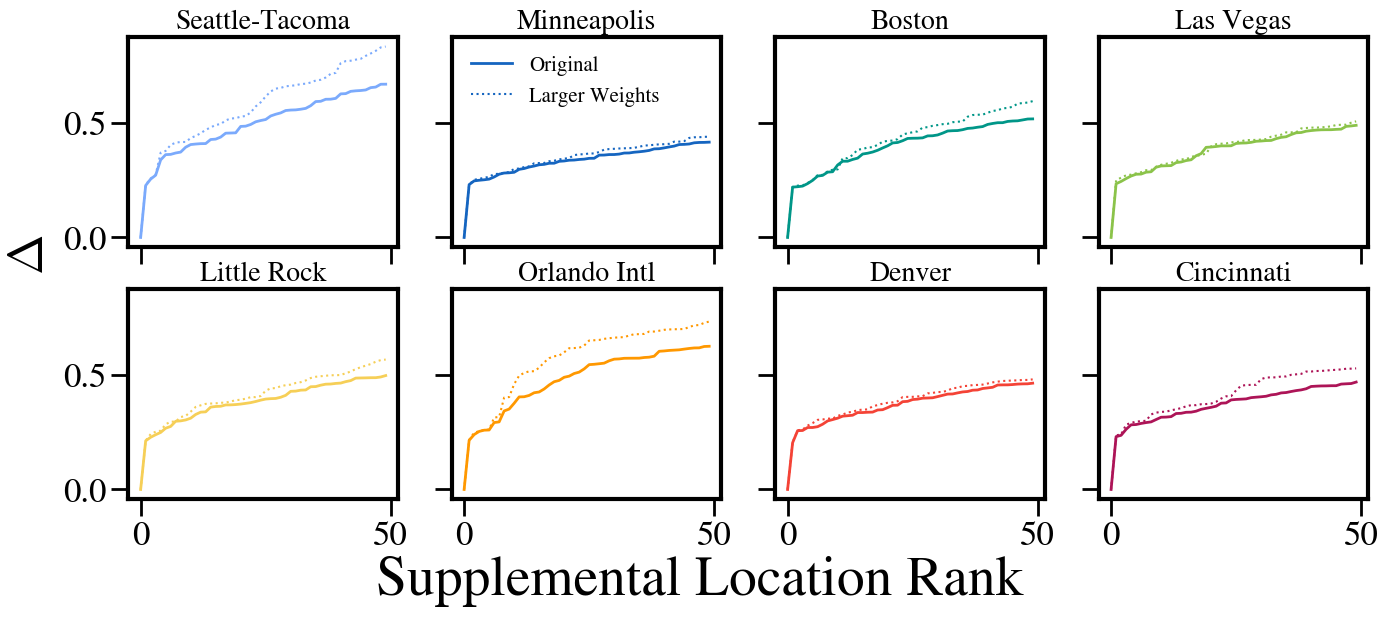

In [151]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        #axes[i,j].hist(np.ravel(gefs_precip[0,:,stat,0])-a_at_stations[stat], range=hrange, bins=25, density=True, alpha=0.3, color='gray',label='Raw GEFS')
        diffs_at_locs = differences_o[:,conus_gp[0], conus_gp[1]]
        axes[i,j].plot(np.arange(50), diffs_at_locs[:,stat], color=colors[stat], lw=2,label='Original')
        diffs_at_locs = differences_w[:,conus_gp[0], conus_gp[1]]
        axes[i,j].plot(np.arange(50), diffs_at_locs[:,stat], color=colors[stat],ls=':', label='Larger Weights')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
axes[0,1].legend(frameon=False, fontsize=15, loc='upper left')

fig.text(x=0.28, y=-0.05, s='Supplemental Location Rank', fontdict={'fontsize': 40})
fig.text(x=0.051, y=0.5, s='$\Delta$', rotation='vertical',fontdict={'fontsize': 35})

### what is a brier score?

             The Brier Score is a strictly proper score function or strictly proper scoring rule that measures the accuracy of probabilistic predictions. 
             For unidimensional predictions, it is strictly equivalent to the mean squared error as applied to predicted probabilities.
             The lower the Brier score is for a set of predictions, the better the predictions are calibrated.


Thank you wikipedia

Perhaps the bias alone cannot give us the full story as to whether the inclusion of SLs is helpful

But I think I can't compare the precipitation _values_, I must compare the _probabilities_...
Do I need to download more data? Or can I calculate the probability from the full GEFS ensemble...

In [140]:
## First, supplemental location data
month = 1
sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/weight_climo_percentiles//blend.supplemental_locations_{month}.co.2p5_weight3.nc')
#unpack lats and lons to index over
lat_arr = sl.latitude.data
lon_arr = sl.longitude.data

xlocs = sl.xlocations.data
ylocs = sl.ylocations.data

differences = sl.differences.data


In [82]:
stat = 0

# the probabilty of precipitation is defined w.r.t some threshold (e.g., it is a precip event if amount of precip > threshold)
# for NBM, this threshold is .254
# but I think we can also set it higher to test specifically the forecasting skill at high precip
# let's stick with .254 mm ...

qm_sl_values = np.ravel(v_with_sl[stat, 0,:,:])


#below formulation is via Hamill+2006
binary_forecast = np.where(qm_sl_values > 0.254, 1., qm_sl_values)
binary_forecast = np.where(binary_forecast < 1., 0., binary_forecast)

prob_at_station = np.sum(binary_forecast) / len(binary_forecast)

In [83]:
prob_at_station

0.39

In [84]:
observed_at_station = [0 if x<0.254 else 1 for x in a_at_stations]
observed_at_station

[1, 0, 0, 0, 1, 0, 1, 1, 1]

Hamill+2006 normalize the Brier score for the forecast by the Brier score calculated from climotology...
So I would need to basically take MSWEP from some time interval and calculate the precip probabilities for each station

In [86]:
#gather precip data for given month
precip_files=[]
for year in range(2002, 2024):
    first_doy = dt.strftime('%j')
    precip_files.append(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{year}/{year}{int(first_doy):03d}.*.nc')))


In [88]:
# we only want the 6h precip accumulation from 0z to 6z
# so only the first 3 files from each chunk

def open_and_sum(files, ny, nx):
    apcp_sums = np.zeros((ny,nx),dtype=np.float32)

    for hour in range(3):
        f = files[hour]
        ds = Dataset(f, mode='r')
        apcp_var = ds.variables['precipitation']
        apcp = np.asarray(apcp_var[0])
        ds.close()
        apcp_sums += apcp
    return apcp_sums

In [89]:
np.shape(precip_files)

(22, 8)

In [92]:
nx = np.shape(lat_arr)[1]
ny = np.shape(lat_arr)[0]

n_processes = 24

print('Processing files, making daily sums')
start = datetime.datetime.now()
print(f'    Using {n_processes} CPUs')
with multiprocessing.Pool(n_processes) as P:
    out = P.starmap(open_and_sum, zip(precip_files, np.repeat(ny, len(precip_files)), np.repeat(nx, len(precip_files))))
out = np.asarray(out)
end=datetime.datetime.now()
print(f'    Finished in {(end-start).total_seconds()}s')
P.close()

Processing files, making daily sums
    Using 24 CPUs
    Finished in 2.981991s


In [93]:
np.shape(out)

(22, 1597, 2345)

In [96]:
climo = np.ravel(out[:,conus_gp[0][stat], conus_gp[1][stat]])
climo

array([9.8876953e-03, 0.0000000e+00, 4.9754639e+00, 0.0000000e+00,
       5.6896362e+00, 0.0000000e+00, 1.8386841e+00, 0.0000000e+00,
       6.2648315e+00, 1.1828613e+00, 1.3830566e-01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 8.9965820e-02, 3.5266113e-01,
       1.3427734e-03, 1.8239746e+00], dtype=float32)

In [99]:
binary_climo = np.where(climo > 0.254, 1., climo)
binary_climo = np.where(binary_climo < 1., 0., binary_climo)

prob_climo = np.sum(binary_climo) / len(binary_climo)
prob_climo

0.3181818181818182

In [102]:
brier_climo = (prob_climo - observed_at_station[stat])**2
brier_climo

0.4648760330578513

In [103]:
brier_forecast = (prob_at_station - observed_at_station[stat])**2
brier_forecast

0.3721

In [105]:
BRIER = 1 - (brier_forecast / brier_climo)
BRIER

0.19957155555555572

In [121]:
np.max(out)

92.183105

In [144]:
observed_at_station = [0 if x<0.254 else 1 for x in a_at_stations]

brier_scores_sl = []
brier_scores = []

# precip ammount above which forecast/analysis will be assigned a 1 for rain (if above) or a 0 for no rain (if below)
precip_threshold = .5

for stat in range(len(st_names)):


    # WITH SL 
    qm_sl_values = np.ravel(v_with_sl[stat, 0,:,:])
    binary_forecast = np.where(qm_sl_values > precip_threshold, 1., qm_sl_values)
    binary_forecast = np.where(binary_forecast < 1., 0., binary_forecast)
    prob_at_station_sl = np.sum(binary_forecast) / len(binary_forecast)

    # WITHOUT SL
    qm_values = np.ravel(v[stat, 0,:])
    binary_forecast = np.where(qm_values > precip_threshold, 1., qm_values)
    binary_forecast = np.where(binary_forecast < 1., 0., binary_forecast)
    prob_at_station = np.sum(binary_forecast) / len(binary_forecast)

    climo = np.ravel(out[:,conus_gp[0][stat], conus_gp[1][stat]])
    binary_climo = np.where(climo > precip_threshold, 1., climo)
    binary_climo = np.where(binary_climo < 1., 0., binary_climo)
    prob_climo = np.sum(binary_climo) / len(binary_climo)

    brier_climo = (prob_climo - observed_at_station[stat])**2
    brier_forecast_sl = (prob_at_station_sl - observed_at_station[stat])**2
    brier_forecast = (prob_at_station - observed_at_station[stat])**2
    
    BRIER_SL = 1 - (brier_forecast_sl / brier_climo)
    BRIER = 1 - (brier_forecast / brier_climo)
    brier_scores_sl.append(BRIER_SL)
    brier_scores.append(BRIER)
    

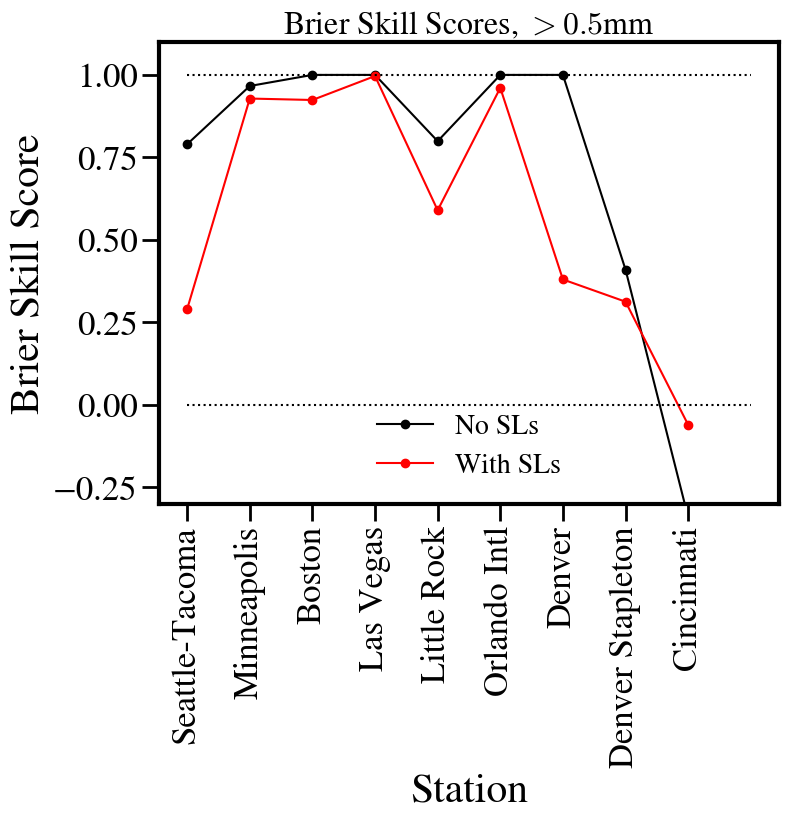

In [153]:
plt.plot(range(len(st_names)), brier_scores, marker='o', color='black', label='No SLs')
plt.plot(range(len(st_names)), brier_scores_sl,marker='o', color='red', label='With SLs')

plt.ylim([-0.3, 1.1])
plt.plot([0,len(st_names)], [0,0], color='black', ls=':')
plt.plot([0,len(st_names)], [1,1], color='black', ls=':')

plt.ylabel('Brier Skill Score')
plt.xlabel('Station')

plt.xticks(range(len(st_names)), [x.title() for x in st_names], rotation='vertical')

plt.title(f'Brier Skill Scores, $> {precip_threshold}$mm', fontsize=23)
plt.legend(frameon=False)

Hamil+2006

                The Brier score is often converted to a skill 
score, its value normalized by the Brier score of a reference forecast such as climatolog. . A Brier skill score (BSS) of 1.0 indicates a perfect probability forecast, while a
BSS of 0.0 should indicate the skill of the reference forecast